# Deconvolution

### A tutorial by Jan Willem de Gee (jwdegee@gmail.com)

Deconvolution is equivalent to selective averaging with correction for overlap between temporally adjacent responses (Dale, 1999), based on the assumption that hemodynamic / pupil responses superimpose linearly over time (Boynton et al., 1996). This analysis is implemented in for example Donner, Sagi, Bonneh & Heeger, JoN, 2008.

This is Python, so let's start with importing some modules:

In [2]:
import os
import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy import *
import math

Let's do inline plotting:

In [3]:
%matplotlib inline 

Let's first create and plot the true pupil response to a transient input. This is called an "Inpulse Response Function" (IRF).

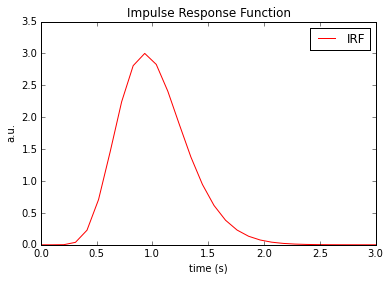

In [4]:
# define an Impulse Response Function:
def pupil_IRF(timepoints, s=1.0/(10**26), n=10.1, tmax=0.93):
    
    """ pupil_IRF defines the IRF (response to a transient input) of the pupil.
    
    Parameters
    ----------
    t: IRF is defined with respect to 't'
    s: scaling factor
    n: sets the width
    tmax: sets the time to peak 
    IRF_len: function is evaluated for t = [0:IRF_len]
    
    Returns
    -------
    y: IRF evaluated for t = [0:IRF_len]
    yprime: IRF first derivative evaluated for t = [0:IRF_len]
    
    """
    
    # in sympy:
    t = Symbol('t')
    y = ( (s) * (t**n) * (math.e**((-n*t)/tmax)) )
    yprime = y.diff(t)
    
    # lambdify:
    y = lambdify(t, y, "numpy")
    yprime = lambdify(t, yprime, "numpy")
    
    # evaluate:
    y = y(timepoints)
    yprime = yprime(timepoints)
    
    return (y, yprime)

# create the IRF:
sample_rate = 10
IRF_len = 3.0 # in seconds
timepoints = np.linspace(0,IRF_len,IRF_len*sample_rate)

IRF, IRF_prime = pupil_IRF(timepoints=timepoints)
IRF = IRF / IRF.std()
IRF_prime = IRF_prime / IRF_prime.std()

# plot the IRF:
fig = plt.figure()
plt.plot(timepoints, IRF, color='r')
# plt.plot(timepoints, IRF_prime, color='g')
plt.legend(['IRF'])
plt.title('Impulse Response Function')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

Let's simulate convolved timeseries data based on this IRF.

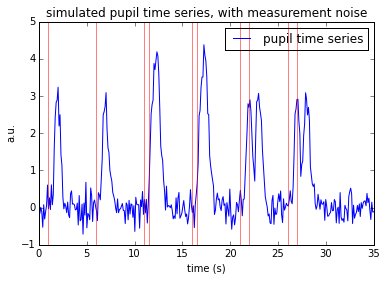

In [5]:
# input:
duration = 35 # in seconds
times = np.array([1,6,11,11.5,16,16.5,21,22,26,27])
input_signal = np.zeros(duration * sample_rate)
for i in times:
    input_signal[i*sample_rate] = 1

# convolve inputs with IRF:    
convolved_signal = (sp.convolve(input_signal, IRF, 'full'))[:-(IRF.shape[0]-1)]

# let's add some noise:
convolved_signal_noise = convolved_signal + np.random.normal(0,0.25,len(convolved_signal))

timepoints = np.linspace(0,duration,duration*sample_rate)
# plot simulated convolved signal with noise:
fig = plt.figure()
plt.plot(timepoints, convolved_signal_noise)
for i in times:
    plt.axvline(i, color='r', alpha=0.5)
plt.legend(['pupil time series'], loc=1)
plt.title('simulated pupil time series, with measurement noise')
plt.xlabel('time (s)')
plt.ylabel('a.u.')

Let's epoch the data and compute mean response.

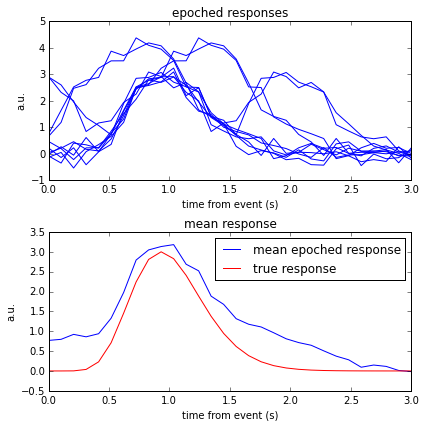

In [6]:
# times for epoching:
epoch_times = [0, 3] # in seconds

# mean response:
epochs = np.vstack([convolved_signal_noise[i+(epoch_times[0]*sample_rate):i+(epoch_times[1]*sample_rate)] for i in times*sample_rate])
mean_response = np.mean(epochs, axis=0)

# plot mean response versus IRF:
timepoints = np.linspace(0,3,3*sample_rate)
fig = plt.figure(figsize=(6,6))
timepoints = np.linspace(epoch_times[0],epoch_times[1],(epoch_times[1]-epoch_times[0])*sample_rate)
fig.add_subplot(211)
for data in epochs:
    plt.plot(timepoints,data, color='b')
plt.title('epoched responses')
plt.xlabel('time from event (s)')
plt.ylabel('a.u.')
fig.add_subplot(212)
plt.plot(timepoints, mean_response, color='b')
plt.plot(timepoints, IRF, color='r')
plt.legend(['mean epoched response', 'true response'])
plt.title('mean response')
plt.xlabel('time from event (s)')
plt.ylabel('a.u.')
fig.tight_layout()

This is obviously not good... what we need to do is to is correct for for overlap between temporally adjacent responses...

We'll have to try deconvolution.

First make a design matrix:

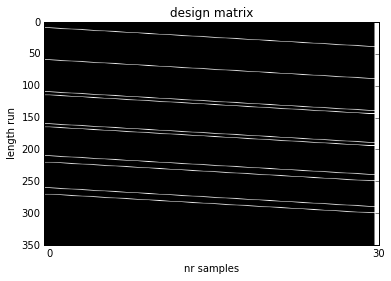

In [9]:
# make design matrix:
nr_samples = 3 * sample_rate # here we define the length of the deconvolution response we're interested in (30 samples = 3-s in our case).
designMatrix = np.zeros((nr_samples, duration*sample_rate))
for i in (times*sample_rate):
    for j in range(int(nr_samples)):
        designMatrix[j,i+j] = 1

# plot design matrix:
plt.figure()
plt.imshow(designMatrix.T, cmap='gray', aspect='auto')
plt.xticks([0,nr_samples])
plt.title('design matrix')
plt.xlabel('nr samples')
plt.ylabel('length run')

Now let's do deconvolution. 

For every regressor (in the above example, we have 30 regressors (the duration in samples of the response we are interested in)  we want to find an associated scalar value (the "beta", $b$) that we can use to scale that particular regressor with, such that it best describes the measured data. In a deconvolution analysis, with a procedure called "multiple regression" we look for betas that minimimize the sum of squares of errors across all $k$ regressors in our design matrix at the same time.

To do so, we set up the following equation (for a derivation, see all the way below):

$ b = (X'X)^{-1} X'y $

In which,

$b$ is a vector containing the betas (size: number of regressors; in the above example: 30). In the case of deconvolution, this vector is the actual deconvolved response to some input;

$X$ is the design matrix (size: length measured time series x number of regressors);

$y$ is the measured BOLD timeseries.

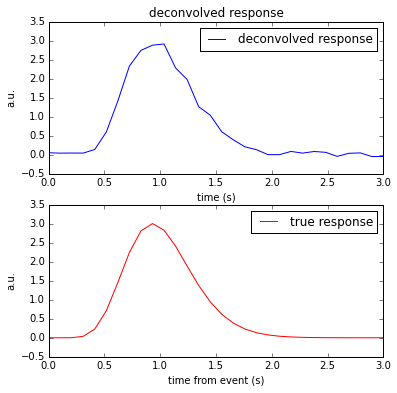

In [8]:
# deconvolution:
designMatrix = np.mat(designMatrix).T
deconvolved_response = ((designMatrix.T * designMatrix).I * designMatrix.T) * np.mat(convolved_signal_noise).T
deconvolved_response = np.array(deconvolved_response)

# plot deconvoled response versus true response:
timepoints = np.linspace(0,3,3*sample_rate)
fig = plt.figure(figsize=(6,6))
fig.add_subplot(211)
plt.plot(timepoints,deconvolved_response, color='b')
plt.xlim(xmax=3)
plt.ylim(ymin=-0.5, ymax=3.5)
plt.legend(['deconvolved response'])
plt.title('deconvolved response')
plt.xlabel('time (s)')
plt.ylabel('a.u.')
fig.add_subplot(212)
plt.plot(timepoints,IRF, color='r')
plt.xlim(xmax=3)
plt.ylim(ymin=-0.5, ymax=3.5)
plt.legend(['true response'])
plt.xlabel('time from event (s)')
plt.ylabel('a.u.')

### Derivation of the multiple regression equation:

In raw form the regression equation is:

$ y = a + b_1X_1 + b_2X_2 + ... + B_kX_k + e $

This says that y, our dependent variable, is composed of a linear part and error. The linear part is composed of an intercept, a, and k independent variables, $X_1 ... X_k$ along with their associated regression weights $b_1 ... b_k$.

In matrix terms, the same equation can be written:

$ y = X b + e $

If we solve for the $b$ weights, we find that

$ b = (X'X)^{-1} X'y $

To give you an idea why it looks like that, first remember the regression equation:

$ y = X b + e $

Let's assume that error will equal zero on average. Now we can simply drop the error term, in order to sketch a proof:

$ y = Xb $

Now we want to solve for $b$, so we need to get rid of $X$. First we will make $X$ into a square, symmetric matrix by premultiplying both sides of the equation by $X'$:

$ X'y = X'Xb $

And now we have a square, symmetric matrix that with any luck has an inverse, which we will call $(X'X)^{-1}$. Multiply both sides by this inverse, and we have:

$ (X'X)^{-1} X'y = (X'X)^{-1} (X'X)b $

It turns out that a matrix multiplied by its inverse is the identity matrix $(A^{-1}A=I)$:

$ (X'X)^{-1} X'y=Ib $

and a matrix multiplied by the identity matrix is itself $(AI = IA = A)$:

$ (X'X)^{-1} X'y=b $

which is the desired result.